# Preprocessing the weatherAUS.csv dataset

**Importing all the required libraries**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

**Missing value visualization**

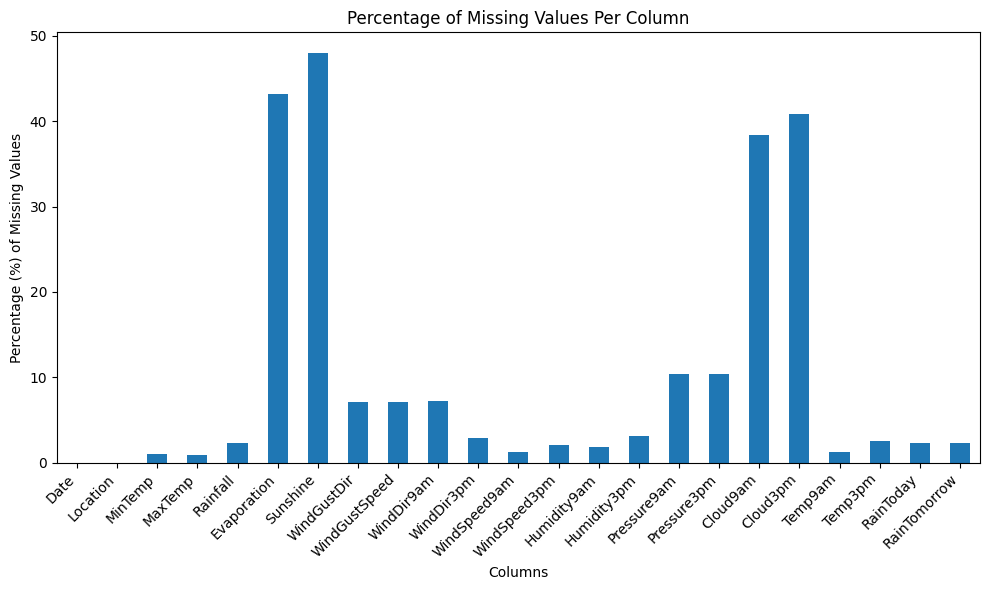

In [ ]:
# Sample code to read the dataset
df = pd.read_csv('/content/drive/MyDrive/dataset/weatherAUS.csv')

# Calculate the percentage of missing values for each column
missing_percentage = df.isnull().mean() * 100  # This directly gives the percentage

# Create a bar plot for the missing percentages
missing_percentage.plot.bar(figsize=(10, 6))
plt.title('Percentage of Missing Values Per Column')
plt.xlabel('Columns')
plt.ylabel('Percentage (%) of Missing Values')
plt.xticks(rotation=45, ha="right")  # Improve readability of x labels
plt.tight_layout()  # Fit everything into the figure cleanly
plt.show()


**Handling missing values**

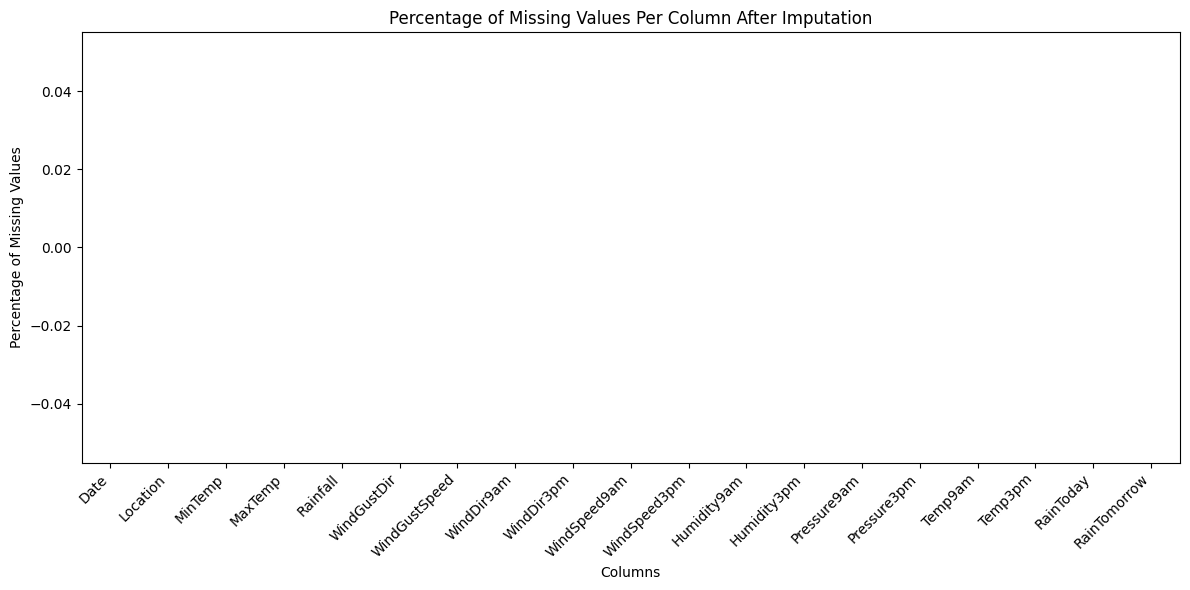

In [ ]:
# Remove columns with very high missing values
df.drop(['Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm'], axis=1, inplace=True)

# Impute missing values in numeric columns with mean
numeric_columns = ['MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed',
                   'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
                   'Temp9am', 'Temp3pm', 'Pressure9am', 'Pressure3pm']
for col in numeric_columns:
    df[col].fillna(df[col].mean(), inplace=True)

# Impute missing values in categorical columns with mode
categorical_columns = ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']
for col in categorical_columns:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Calculate the percentage of missing values for each column
missing_values_percentage = df.isnull().mean() * 100

# Plotting the percentage of missing values
missing_values_percentage.plot(kind='bar', figsize=(12, 6))
plt.title('Percentage of Missing Values Per Column After Imputation')
plt.xlabel('Columns')
plt.ylabel('Percentage of Missing Values')
plt.xticks(rotation=45, ha="right")  # Improve readability of x labels
plt.tight_layout()  # Adjust the layout
plt.show()

**Min-Max Scaling**

1. **Min-Max Scaling**: The numerical columns are scaled using Min-Max scaling, which transforms the data to fall within a specified range (typically 0 to 1). This is crucial for models sensitive to the magnitude of features, ensuring that all numerical features contribute equally to the model training.

2. **Date Handling**: The 'Date' column, which represents dates, is transformed into a numerical format. This is achieved by calculating the number of days from the minimum date in the dataset to each date. This numerical representation makes it possible to use the 'Date' feature in machine learning models, which require numerical input.

In [ ]:
# Initialize Min-Max scaler
min_max_scaler = MinMaxScaler()

# Define the numerical columns
numerical_cols = ['MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed',
                  'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
                  'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm']

# Apply Min-Max scaling to the numerical columns
df[numerical_cols] = min_max_scaler.fit_transform(df[numerical_cols])

# Ensure 'Date' is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Create a new column with the numerical representation of the date
df['Date_numeric'] = (df['Date'] - df['Date'].min()).dt.days

# Apply Min-Max scaling to this new 'Date_numeric' column
df[['Date_numeric']] = min_max_scaler.fit_transform(df[['Date_numeric']])

# Rename the scaled 'Date_numeric' to 'Date_scaled' for clarity
df.rename(columns={'Date_numeric': 'Date_scaled'}, inplace=True)

# Drop the original 'Date' column if it's no longer needed
df.drop('Date', axis=1, inplace=True)

**Encoding Categorical Variables**

- **Label Encoding Validation**: By transforming 'RainToday' and 'RainTomorrow' into numeric formats, we ensure these binary features are readily usable by algorithms. It's crucial, however, to only apply label encoding to features where it does not introduce an ordinal relationship that doesn't exist, which is why it's suitable for binary features in this dataset.

- **One-Hot Encoding Validation**: Applying one-hot encoding to 'Location', 'WindGustDir', 'WindDir9am', and 'WindDir3pm' avoids the introduction of a false ordinal relationship among the categories of these features. Since these features are nominal with no inherent order, one-hot encoding allows the model to treat each category as an independent feature, improving the model's ability to learn from these variables.


In [ ]:
# Label Encoding for 'RainToday' and 'RainTomorrow'
label_encoder = LabelEncoder()
df['RainToday'] = label_encoder.fit_transform(df['RainToday'].astype(str))
df['RainTomorrow'] = label_encoder.fit_transform(df['RainTomorrow'].astype(str))

# One-Hot Encoding for 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'
df = pd.get_dummies(df, columns=['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'])

**Scaling Numerical Features**

1. **Min-Max Scaling (Normalization)**: This method scales the numerical features to a fixed range, typically between 0 and 1. It is achieved by subtracting the minimum value of the feature and then dividing by the difference between the maximum and minimum values. Min-Max scaling is suitable when the distribution of the data does not follow a Gaussian distribution (i.e., it is not normally distributed).

2. **Standard Scaling (Standardization)**: This method transforms the numerical features to have a mean of 0 and a standard deviation of 1. It is achieved by subtracting the mean of the feature and then dividing by the standard deviation. Standard scaling is suitable when the data follows a Gaussian distribution.


 **Result**: The resulting DataFrame contains both the original numerical features and their scaled versions, allowing for improved model performance and interpretability.

In [ ]:
# Define the numerical features
numerical_cols = ['MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed',
                  'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
                  'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm']

# Initialize MinMaxScaler and StandardScaler
min_max_scaler = MinMaxScaler()
std_scaler = StandardScaler()

# Apply Min-Max scaling (Normalization) and create new columns for the normalized features
df_normalized = pd.DataFrame(min_max_scaler.fit_transform(df[numerical_cols]),
                             columns=[f"{col}_minmax" for col in numerical_cols],
                             index=df.index)

# Apply Standard scaling (Standardization) and create new columns for the standardized features
df_standardized = pd.DataFrame(std_scaler.fit_transform(df[numerical_cols]),
                               columns=[f"{col}_std" for col in numerical_cols],
                               index=df.index)

# Concatenate the new scaled columns to the original dataframe
df = pd.concat([df, df_normalized, df_standardized], axis=1)

# Display the resulting DataFrame
print(df)

         MinTemp   MaxTemp  Rainfall  WindGustSpeed  WindSpeed9am  \
0       0.516509  0.523629  0.001617       0.294574      0.153846   
1       0.375000  0.565217  0.000000       0.294574      0.030769   
2       0.504717  0.576560  0.000000       0.310078      0.146154   
3       0.417453  0.620038  0.000000       0.139535      0.084615   
4       0.613208  0.701323  0.002695       0.271318      0.053846   
...          ...       ...       ...            ...           ...   
145455  0.266509  0.533081  0.000000       0.193798      0.100000   
145456  0.285377  0.568998  0.000000       0.124031      0.100000   
145457  0.327830  0.599244  0.000000       0.240310      0.069231   
145458  0.384434  0.601134  0.000000       0.170543      0.100000   
145459  0.551887  0.529704  0.000000       0.263839      0.130769   

        WindSpeed3pm  Humidity9am  Humidity3pm  Pressure9am  Pressure3pm  ...  \
0           0.275862         0.71         0.22     0.449587       0.4800  ...   
1        

# **Handling outliers**

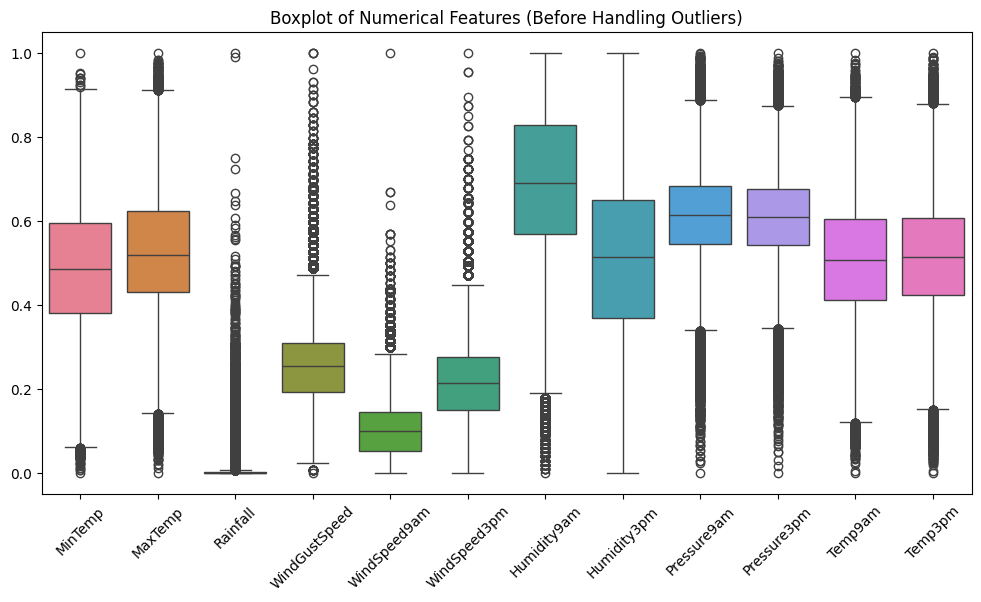

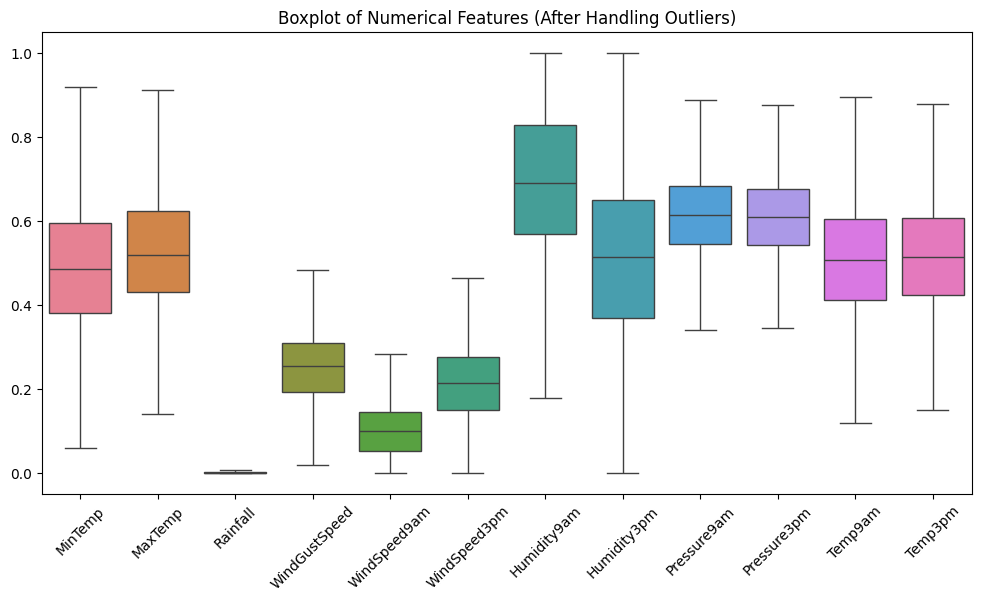

In [ ]:
# Define the numerical columns
numerical_cols = ['MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed',
                  'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
                  'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm']

# Function to handle outliers
def handle_outliers(col):
    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return np.clip(col, lower_bound, upper_bound)

# Display box plot before handling outliers
plt.figure(figsize=(12, 6))
plt.title("Boxplot of Numerical Features (Before Handling Outliers)")
sns.boxplot(data=df[numerical_cols])
plt.xticks(rotation=45)
plt.show()

# Handling outliers by applying the handle_outliers function
df[numerical_cols] = df[numerical_cols].apply(handle_outliers, axis=0)

# Display box plot after handling outliers
plt.figure(figsize=(12, 6))
plt.title("Boxplot of Numerical Features (After Handling Outliers)")
sns.boxplot(data=df[numerical_cols])
plt.xticks(rotation=45)
plt.show()

**Saving the preprocessed data**

In [ ]:
# Split the dataset into training and testing sets with stratification if it's a classification problem
# Stratify ensures that both train and test sets have the same proportion of class labels as the input dataset
X = df.drop('RainTomorrow', axis=1)  # or your target column if different
y = df['RainTomorrow']  # or your target column if different

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Recombine the split sets with the target variable for saving
train_df = pd.concat([train_X, train_y], axis=1)
test_df = pd.concat([test_X, test_y], axis=1)

# Save the full preprocessed DataFrame
df.to_csv('/content/drive/MyDrive/dataset/weatherAUS_preprocessed.csv', index=False)

# Save the preprocessed training and testing sets
train_df.to_csv('/content/drive/MyDrive/dataset/weatherAUS_train.csv', index=False)
test_df.to_csv('/content/drive/MyDrive/dataset/weatherAUS_test.csv', index=False)

# Logistic regression model


This code loads a preprocessed dataset, splits it for training and testing, creates a pipeline to scale features and fit a logistic regression model, makes predictions, and visualizes the resulting confusion matrix to evaluate the model's performance.

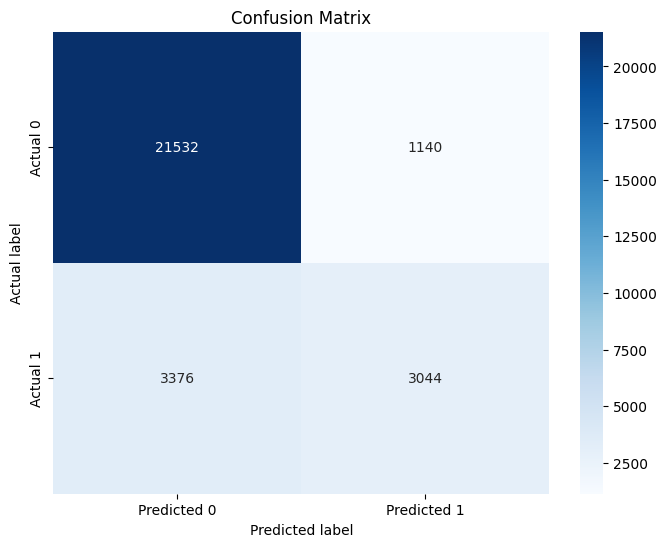

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Load your preprocessed dataset
df = pd.read_csv('/content/drive/MyDrive/dataset/weatherAUS_preprocessed.csv')



# Splitting the dataset into features and target variable
X = df.drop('RainTomorrow', axis=1)
y = df['RainTomorrow']

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating a pipeline that first scales the data then applies logistic regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logistic', LogisticRegression(solver='liblinear', max_iter=1000))
])

# Fitting the model using the pipeline. The pipeline will first transform the data using StandardScaler and then fit the logistic regression model.
pipeline.fit(X_train, y_train)

# You can access the logistic regression model directly via pipeline.named_steps['logistic']
logistic_model = pipeline.named_steps['logistic']

# The model is now fitted and can be used to make predictions on the scaled test data automatically
y_pred = pipeline.predict(X_test)

# Generating the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualizing the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()


This confusion matrix represents the performance of a logistic regression model used for rain prediction, with two classes: '0' (no rain) and '1' (rain). Here's the interpretation:

- **True Negatives (TN)**: The top left cell (21532) shows the number of days correctly predicted as no rain.
- **False Positives (FP)**: The top right cell (1140) indicates the days falsely predicted as having rain.
- **False Negatives (FN)**: The bottom left cell (3376) represents the days when it rained, but the model predicted no rain.
- **True Positives (TP)**: The bottom right cell (3044) is the number of days correctly predicted to have rain.

Using this matrix, several metrics can be calculated:
- **Accuracy**: (TP + TN) / (TP + TN + FP + FN), the overall correctness of the model.
- **Precision** (for predicting rain): TP / (TP + FP), the correctness when the model predicts rain.
- **Recall** (for predicting rain): TP / (TP + FN), the ability of the model to find all the rainy days.
- **F1 Score**: 2 * (Precision * Recall) / (Precision + Recall), a balance between precision and recall.

The model is better at predicting non-rainy days (TN) than rainy days (TP), considering the numbers. The number of false negatives is relatively high, indicating a considerable amount of rainy days were missed.

In [ ]:
# Classification Report for precision, recall, and F1 score
print(classification_report(y_test, y_pred, target_names=['No Rain', 'Rain']))

# Calculating and Displaying Specificity and Classification Error
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
classification_error = (fp + fn) / (tp + tn + fp + fn)

print(f"Specificity: {specificity:.2f}")
print(f"Classification Error: {classification_error:.2f}")

              precision    recall  f1-score   support

     No Rain       0.86      0.95      0.91     22672
        Rain       0.73      0.47      0.57      6420

    accuracy                           0.84     29092
   macro avg       0.80      0.71      0.74     29092
weighted avg       0.83      0.84      0.83     29092

Specificity: 0.95
Classification Error: 0.16


Based on the provided classification report and additional metrics for the logistic regression model predicting rain:

- **No Rain (Class 0)**
  - **Precision**: 86% of the instances predicted as no rain were actually no rain.
  - **Recall**: 95% of the actual no rain instances were correctly predicted by the model.
  - **F1-Score**: A harmonic mean of precision and recall for no rain predictions, indicating a high balance at 0.91.

- **Rain (Class 1)**
  - **Precision**: 73% of the instances predicted as rain actually had rain.
  - **Recall**: Only 47% of the actual rain instances were correctly predicted.
  - **F1-Score**: The F1-score for rain predictions is 0.57, which is lower compared to no rain, indicating a worse balance between precision and recall for this class.

- **Accuracy**: The model correctly predicted the weather (rain or no rain) 84% of the time.

- **Macro Avg**: The average precision, recall, and F1-score without taking class imbalance into account are 80%, 71%, and 74%, respectively.

- **Weighted Avg**: Precision, recall, and F1-scores are averaged according to the support (the number of true instances for each label), resulting in 83%, 84%, and 83%, respectively.

- **Specificity**: 95% specificity means the model is very good at identifying true negatives (no rain days).

- **Classification Error**: 16% of the predictions were incorrect.



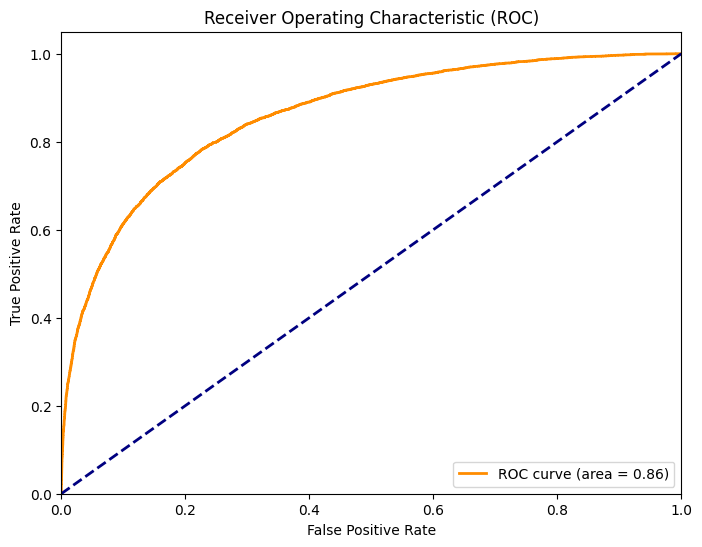

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming `pipeline` is your fitted model and it can predict probabilities
# Get the scores (probabilities) of the positive class
y_scores = pipeline.predict_proba(X_test)[:, 1]

# Generate ROC curve values: false positive rates, true positive rates
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

# Calculate Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


The ROC curve here is the orange line, and the following points can be made:

- The area under the curve (AUC) is 0.86. This value ranges from 0 to 1, where 1 indicates a perfect model and 0.5 represents a model with no discriminatory ability (random guessing). An AUC of 0.86 suggests that the model has a good level of separability and can distinguish between the two classes (rain and no rain) well.
- The curve is significantly above the dashed blue line, which represents random chance (AUC = 0.5). This demonstrates the model's good performance.
- The closer the curve follows the left-hand border and then the top border of the ROC space, the more accurate the test.
- The curve does not reach the perfect top-left corner, indicating there is room for improvement, especially in terms of reducing the false positive rate while maintaining or improving the true positive rate.

**K-fold cross-validation** is a technique used to assess the generalizability and robustness of a predictive model.

- **Bias-Variance Trade-Off**: It helps in striking a balance between underfitting and overfitting. By using multiple splits, you ensure that the model is tested on different subsets of the data, providing a more comprehensive performance evaluation.

- **Model Validation**: It's a way to validate the model's performance on unseen data. If a model performs well on cross-validation, it's more likely to perform well on new data.

- **Stratification**: When using 'StratifiedKFold', it ensures that each fold is a good representative of the whole by having the same proportion of class labels, which is crucial for imbalanced datasets.

In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Assuming 'df' is your preprocessed DataFrame and 'RainTomorrow' is the target variable
X = df.drop('RainTomorrow', axis=1)
y = df['RainTomorrow']

# Initialize a pipeline with a scaler and logistic regression model
# This ensures scaling is applied within each cross-validation fold
pipeline = make_pipeline(StandardScaler(), LogisticRegression(solver='liblinear', max_iter=1000))

# Initialize Stratified K-Fold to maintain the percentage of samples for each class
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform k-fold cross-validation
# Here we use 'accuracy' as the score to evaluate. You can choose other metrics like 'roc_auc', 'f1', etc.
scores = cross_val_score(pipeline, X, y, cv=kfold, scoring='accuracy')

# Print the accuracy for each fold
print("Accuracy for each fold: ", scores)

# Print the mean accuracy across all folds
print("Mean cross-validation accuracy: ", scores.mean())

# Compare this mean accuracy to your baseline model's accuracy to check for improvement
from sklearn.dummy import DummyClassifier

# Assuming y is your target variable from the dataframe 'df'
dummy = DummyClassifier(strategy='most_frequent', random_state=42)
dummy_scores = cross_val_score(dummy, X, y, cv=kfold, scoring='accuracy')

# Print the mean accuracy for the baseline model
print("Mean baseline accuracy: ", dummy_scores.mean())

# Now you can compare it to your logistic regression model's accuracy
print("Mean logistic regression accuracy: ", scores.mean())
print("Improvement over baseline: ", scores.mean() - dummy_scores.mean())



Accuracy for each fold:  [0.84607452 0.846762   0.84586828 0.8454558  0.84504331]
Mean cross-validation accuracy:  0.8458407809707136
Mean baseline accuracy:  0.7808538429808882
Mean logistic regression accuracy:  0.8458407809707136
Improvement over baseline:  0.06498693798982536


Training Accuracy: 0.8465901278702048
Validation Accuracy: 0.8447683211879554
Cross-validation scores: [0.84607452 0.846762   0.84586828 0.8454558  0.84504331]
Mean CV Accuracy: 0.8458407809707136


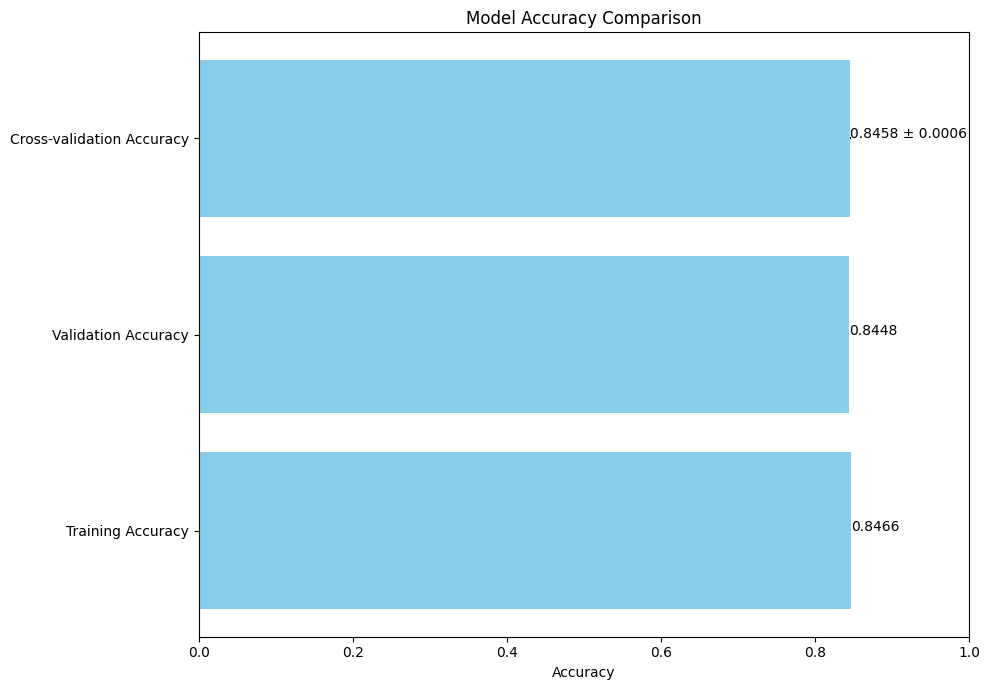

In [ ]:
# Assuming 'df' is your preprocessed DataFrame and 'RainTomorrow' is the target variable
X = df.drop('RainTomorrow', axis=1)
y = df['RainTomorrow']

# Splitting the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating a pipeline that includes scaling and logistic regression
pipeline = make_pipeline(StandardScaler(), LogisticRegression(solver='liblinear', max_iter=1000))

# Fitting the model to the training data
pipeline.fit(X_train, y_train)

# Evaluating the model on the training set
train_accuracy = pipeline.score(X_train, y_train)

# Evaluating the model on the validation set
val_accuracy = pipeline.score(X_val, y_val)

print(f"Training Accuracy: {train_accuracy}")
print(f"Validation Accuracy: {val_accuracy}")

# Perform k-fold cross-validation to further evaluate the model
from sklearn.model_selection import cross_val_score, StratifiedKFold

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipeline, X, y, cv=kfold, scoring='accuracy')

print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV Accuracy: {np.mean(cv_scores)}")

# Calculating mean and standard deviation of cross-validation scores
cv_mean = np.mean(cv_scores)
cv_std = np.std(cv_scores)

# Visualizing training, validation, and cross-validation accuracies
plt.figure(figsize=(10, 7))
plt.barh(['Training Accuracy', 'Validation Accuracy', 'Cross-validation Accuracy'],
         [train_accuracy, val_accuracy, cv_mean], xerr=[0, 0, cv_std], color='skyblue')
plt.xlabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.xlim(0, 1.0)  # Assuming accuracy is from 0 to 1

# Annotate the exact scores on the bars
for index, value in enumerate([train_accuracy, val_accuracy, cv_mean]):
    plt.text(value, index, f"{value:.4f} ± {cv_std:.4f}" if index == 2 else f"{value:.4f}")

plt.tight_layout()
plt.show()

The horizontal bar chart showing three types of accuracy measurements for a logistic regression model predicting 'RainTomorrow':

- **Training Accuracy**: The model achieves an accuracy of 0.8466 on the data it was trained on.
- **Validation Accuracy**: The model's accuracy on the validation set (unseen during training) is 0.8448.
- **Cross-validation Accuracy**: The average accuracy from a 5-fold stratified cross-validation is 0.8458, with a very low standard deviation of 0.0006, indicating consistency across the folds.

Interpretation:
- The model is consistent across training, validation, and cross-validation, suggesting that it generalizes well and is not overfitting.
- The tight error bar on the cross-validation accuracy shows that the model's performance is stable across different subsets of data.

In [ ]:

# Assuming 'df' is your DataFrame and 'RainTomorrow' is the target variable
X = df.drop('RainTomorrow', axis=1)
y = df['RainTomorrow']

# Create a pipeline with a standard scaler and logistic regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logistic', LogisticRegression(solver='liblinear'))
])

# Define a grid of hyperparameters to search
# Here, we are searching over two hyperparameters: C (regularization strength) and penalty (type of regularization)
param_grid = {
    'logistic__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'logistic__penalty': ['l1', 'l2']
}

# Set up GridSearchCV with the pipeline, parameter grid, and desired scoring metric
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=1)

# Fit the GridSearchCV object to the data
grid_search.fit(X, y)

# Print the best parameters and the best score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation accuracy: ", grid_search.best_score_)

# Get the best estimator directly
best_model = grid_search.best_estimator_

NameError: name 'df' is not defined

## Naive Bayes model

**Fitting the naive bayes model**

This code loads a preprocessed dataset, creates a pipeline with Gaussian Naive Bayes after scaling the features, and then fits the model to the training data. It evaluates the model's accuracy on the test set and prints the result.

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
# Load your preprocessed dataset
df = pd.read_csv('/content/drive/MyDrive/dataset/weatherAUS_preprocessed.csv')

# Assuming 'df' is your preprocessed DataFrame and 'RainTomorrow' is the target variable
X = df.drop('RainTomorrow', axis=1)
y = df['RainTomorrow']

# Splitting the dataset into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating a pipeline that includes scaling and Gaussian Naive Bayes
pipeline = make_pipeline(StandardScaler(), GaussianNB())

# Fitting the model to the training data
pipeline.fit(X_train, y_train)

# Making predictions on the test set
y_pred = pipeline.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy}")

Test Accuracy: 0.6987487969201155


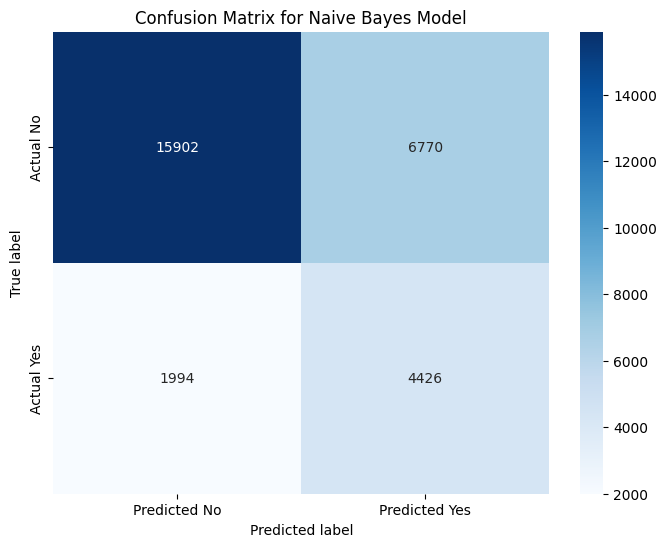

              precision    recall  f1-score   support

          No       0.89      0.70      0.78     22672
         Yes       0.40      0.69      0.50      6420

    accuracy                           0.70     29092
   macro avg       0.64      0.70      0.64     29092
weighted avg       0.78      0.70      0.72     29092



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y_test are the true labels and y_pred are the predictions made by the model

# Generating the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualizing the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['Predicted No', 'Predicted Yes'], yticklabels=['Actual No', 'Actual Yes'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix for Naive Bayes Model')
plt.show()


The provided confusion matrix represents the performance of a Naive Bayes model for a binary classification task:

- **True Negatives (TN)**: 15902 instances were correctly predicted as "No" (e.g., no rain).
- **False Positives (FP)**: 6770 instances were incorrectly predicted as "Yes" when they were actually "No".
- **False Negatives (FN)**: 1994 instances were incorrectly predicted as "No" when they were actually "Yes".
- **True Positives (TP)**: 4426 instances were correctly predicted as "Yes" (e.g., rain).

This indicates that the model is generally better at predicting the "No" class, with a high number of True Negatives. However, there is a significant number of False Positives, which may indicate a higher tendency for the model to err on the side of predicting the "Yes" class when it's actually "No". The number of False Negatives suggests that the model misses predicting "Yes" quite a few times as well. The performance metrics such as accuracy, precision, recall, and F1-score would be needed to give a complete evaluation of the model's performance.

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Assuming y_test and y_pred are already defined from your Naive Bayes model prediction

# Generate and print the classification report for precision, recall, and F1 score
print(classification_report(y_test, y_pred, target_names=['No', 'Yes']))

# Calculate the confusion matrix to use for calculating classification error and specificity
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

# Classification error (also known as Misclassification Rate)
classification_error = (fp + fn) / float(tp + tn + fp + fn)
print(f"Classification Error: {classification_error:.2f}")

# Specificity (True Negative Rate)
specificity = tn / (tn + fp)
print(f"Specificity: {specificity:.2f}")


              precision    recall  f1-score   support

          No       0.89      0.70      0.78     22672
         Yes       0.40      0.69      0.50      6420

    accuracy                           0.70     29092
   macro avg       0.64      0.70      0.64     29092
weighted avg       0.78      0.70      0.72     29092

Classification Error: 0.30
Specificity: 0.70


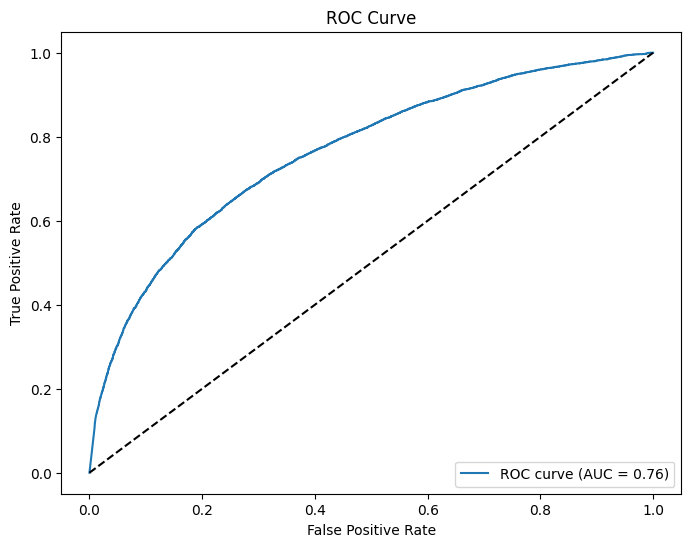

Adjusted Metrics:
Accuracy: 0.6934
Precision: 0.3912
Recall: 0.7002
F1 Score: 0.5019


In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'pipeline' is your fitted pipeline that includes the Naive Bayes model
# And 'X_test' and 'y_test' are your testing dataset

# Step 1: Get the predicted probabilities for the positive class
y_scores = pipeline.predict_proba(X_test)[:, 1]

# Step 2: Calculate ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = roc_auc_score(y_test, y_scores)

# Step 3: Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()




The ROC curve you provided is a graphical representation of a model's diagnostic ability. Here's an interpretation:

- The curve plots the True Positive Rate (TPR, sensitivity) against the False Positive Rate (FPR, 1-specificity) at various threshold settings.
- The Area Under the Curve (AUC) is 0.76, which indicates a good predictive ability, higher than a random chance (AUC of 0.5), but not perfect.
- The curve stays well above the diagonal line, which represents the performance of a random classifier. The closer the curve follows the left-hand border and then the top border of the ROC space, the more accurate the test.
- The point where the curve bends represents the threshold with the best balance between the True Positive Rate and False Positive Rate for this model.

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Original predictions (before adjusting threshold)
y_pred_original = pipeline.predict(X_test)

# Calculate metrics with the original predictions
print("Original Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_original):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_original):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_original):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_original):.4f}\n")

# Assume y_scores are the predicted probabilities for the positive class
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

# Calculate Youden's J statistic
j_statistic = tpr - fpr
optimal_idx = np.argmax(j_statistic)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal Threshold based on Youden's J statistic: {optimal_threshold}")

# Step 4: Choose a new threshold from the ROC curve that suits your need
# This is a manual step depending on your specific requirement (e.g., balancing precision and recall)
# For demonstration, let's say you chose a threshold that gives you higher recall
new_threshold = optimal_threshold  # Example threshold

# Step 5: Apply the new threshold to adjust classification decisions
y_pred_adjusted = (y_scores >= new_threshold).astype(int)

# Now you can calculate metrics using the adjusted predictions to see the impact
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("Adjusted Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_adjusted):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_adjusted):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_adjusted):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_adjusted):.4f}")

Original Metrics:
Accuracy: 0.6987
Precision: 0.3953
Recall: 0.6894
F1 Score: 0.5025

Optimal Threshold based on Youden's J statistic: 0.6710179444480715
Adjusted Metrics:
Accuracy: 0.7110
Precision: 0.4066
Recall: 0.6741
F1 Score: 0.5072


The Interpretation of the performance of the classification model before and after adjusting the decision threshold based on Youden's J statistic:

- **Original Metrics (Before Threshold Adjustment):**
  - **Accuracy**: 69.87% of the predictions were correct.
  - **Precision**: 39.53% of the predicted positives were actual positives.
  - **Recall**: 68.94% of the actual positives were correctly identified.
  - **F1 Score**: The harmonic mean of precision and recall was 50.25%.

- **Optimal Threshold based on Youden's J statistic**: 0.6710. This value is chosen to maximize the difference between the True Positive Rate and False Positive Rate, indicating a good balance between sensitivity and specificity for the model.

- **Adjusted Metrics (After Threshold Adjustment):**
  - **Accuracy**: Slightly increased to 71.10%, indicating a small improvement in overall correctness.
  - **Precision**: Slightly increased to 40.66%, indicating a better proportion of true positives among the predicted positives.
  - **Recall**: Slightly decreased to 67.41%, indicating a small reduction in the model's ability to detect all actual positives.
  - **F1 Score**: Slightly improved to 50.72%, indicating a better balance between precision and recall after adjusting the threshold.

The adjustment of the threshold resulted in a trade-off: a slight decrease in recall for a slight increase in precision, leading to an overall increase in accuracy and F1 score. This suggests that by adjusting the threshold, the model has become slightly more conservative in predicting the positive class, reducing false positives more than it increased false negatives.

In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Assuming 'X' and 'y' are your features and target variable from the preprocessed DataFrame

# Creating a pipeline with a scaler and Gaussian Naive Bayes
pipeline = make_pipeline(StandardScaler(), GaussianNB())

# Evaluating model performance with cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipeline, X, y, cv=kfold, scoring='accuracy')

print(f"CV Accuracy: {cv_scores.mean()} ± {cv_scores.std()}")


CV Accuracy: 0.7002543654612952 ± 0.0030288993794759926


**Interpretation**

*   **Balanced Performance**: The model seems to balance well between not overfitting and not underfitting. The accuracy is reasonably consistent across training, validation/testing, and cross-validation.
*   **Threshold Adjustment Impact**: Adjusting the classification threshold has improved model accuracy and F1 score slightly, indicating that it might have been somewhat biased towards predicting the majority class or was too conservative in predicting the positive class initially. The improvement in precision and recall, along with accuracy, post-adjustment is a positive outcome.

*   **Model Complexity**: Naive Bayes models, by their nature, are relatively simple and make strong independence assumptions. This simplicity often prevents them from overfitting but can also limit their capacity to capture more complex patterns in the data, impacting their maximum achievable accuracy.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Assuming 'X' and 'y' are your features and target variable from the preprocessed DataFrame

# Creating a pipeline that includes scaling and Gaussian Naive Bayes
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('naive_bayes', GaussianNB())
])

# Define a grid of hyperparameters to search
# For GaussianNB, we can tune the 'var_smoothing' parameter
param_grid = {
    'naive_bayes__var_smoothing': np.logspace(0, -9, num=100)
}

# Set up GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=1)

# Fit the GridSearchCV object to the data
grid_search.fit(X, y)

# Print the best parameters and the best score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation accuracy: ", grid_search.best_score_)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters found:  {'naive_bayes__var_smoothing': 1.0}
Best cross-validation accuracy:  0.7491406572253541


This result suggests that with the given dataset and feature preprocessing, the Gaussian Naive Bayes model with var_smoothing set to 1.0 is expected to correctly classify about 74.91% of new data instances, according to the cross-validation performed.